In [1]:
%matplotlib inline
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D
from keras import optimizers, regularizers, initializers
from datetime import datetime
from keras.callbacks import ModelCheckpoint, TensorBoard
import numpy as np
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import csv
random_state = 1
np.random.seed(random_state)

Using TensorFlow backend.


### Import Data

In [2]:
## look data with pandas
train_file = "data/rupturemodel_train.txt"
val_file = "data/rupturemodel_xvalidate.txt"
test_file = "data/rupturemodel_test.txt"

df_train= pd.read_csv(train_file, sep=" ", header = None)
df_val= pd.read_csv(val_file, sep=" ", header = None)
df_test= pd.read_csv(test_file, sep=" ", header = None)

coloumns =  ['height', 'width', 'sxx', 'sxy', 'syy', 'sdrop', 'mud', 'dc', 'value']
df_train.columns = coloumns
df_val.columns = coloumns
df_test.columns = coloumns

### Data processing
We use StandardScaler preprocessing method of scikit. It standardizes features 
by removing the mean and scaling to unit variance

In [3]:
from keras.utils import to_categorical

mms = StandardScaler()
X_train = mms.fit_transform(df_train.drop('value', axis=1))
Y_train = to_categorical(df_train['value'].values)

X_val = mms.fit_transform(df_val.drop('value', axis=1))
Y_val = to_categorical(df_val['value'].values)

X_test = mms.fit_transform(df_test.drop('value', axis=1))
Y_test = to_categorical(df_test['value'].values)

### Plot Heatmap
Heatmap Plots rectangular data as a color-encoded matrix. This is particularly interesting because the plot gives us a sense of relationship amoung the features. It also helps to decide to if a feature be deleted or kept.

In [4]:
# import seaborn as sns
# plt.figure(figsize=(18, 10))
# plt.rcParams.update({'font.size': 14})
# sns.heatmap(df.corr(), annot = True)

### Plot histogram of data
Histogram helps us a to see the distribution of data. It also helps to decide to if a feature be deleted or kept.

In [5]:
#plot Histogram
# plt.figure(figsize=(15, 5))
# for i, feature in enumerate(df.columns):
#     plt.subplot(1, 11, i+1)
#     df[feature].plot(kind='hist')
#     plt.xlabel(feature)

### Spliting data into train and test

In [6]:
# X, Y = shuffle(X, Y, random_state=42)
# X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=random_state)

# print(X_train.shape)
# print(Y_train.shape)

### Model setup

In [7]:
def get_saved_model():
    loaded_model = load_model('./logs/rupture')
    loaded_model.load_weights('./logs/rupture_weights.epoch.499.hdf5')
    return loaded_model

def get_model(train_status, random_seed):
    if train_status == 'new':   
        model = Sequential()
        model.add(Dense(12, kernel_initializer=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=random_seed), activation = 'relu', input_dim = X_train.shape[1], name='layer_1'))
        model.add(Dense(Y_train.shape[1], activation="softmax", name='Output_layer'))
        model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
        return model
    elif train_status == 'retrain':
        model = get_saved_model()
        model.compile('adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
        return model
        

### Training

In [28]:
# Training
random_seed=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 40, 60, 80, 100]
scores=[]
for i in range(len(random_seed)):
    training_epochs = 1000
    train_status = 'new' # retrain or new
    model = get_model(train_status, random_seed[i])
    
    filepath = './logs/random_seed_'+ str(random_seed[i]) +'_{epoch:02d}.hdf5'
    checkpoint = ModelCheckpoint(filepath, verbose=0, save_weights_only=True, period=training_epochs)
#   tbCallBack = TensorBoard(log_dir=path, histogram_freq=1, write_graph=True)

    history = model.fit(X_train, Y_train, batch_size = 10, epochs = training_epochs, 
               validation_data=(X_val, Y_val), verbose=0, callbacks = [checkpoint])

    scores.append(model.evaluate(X_test, Y_test, batch_size=10))
    print('Test score :', score)

370/400 [==========================>...] - ETA: 0sTest score : [0.43714914470911026, 0.80999999791383748]


15


<function matplotlib.pyplot.show>

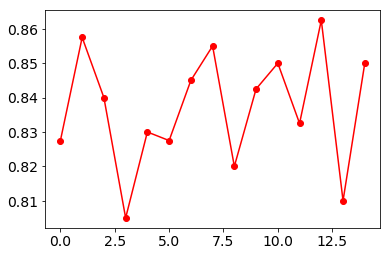

In [46]:
import pickle
data ={'scores':scores}
pickle_file_name="rupture_scores.pkl"
file = open(pickle_file_name, 'wb')
pickle.dump(data, file)
file.close()

# if (is_file_exist):
#     file = open(pickle_file_name, 'rb')
#     data = pickle.load(file)

new_scores= []
indexs = []
for i in range(len(scores)):
    new_scores.append((scores[i])[1])
    indexs.append(i)
    
print(len(new_scores))
plt.plot(indexs, new_scores, '-or')
plt.show

In [68]:
loaded_model = get_model(train_status, 1)
loaded_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_1 (Dense)              (None, 12)                108       
_________________________________________________________________
Output_layer (Dense)         (None, 2)                 26        
Total params: 134
Trainable params: 134
Non-trainable params: 0
_________________________________________________________________


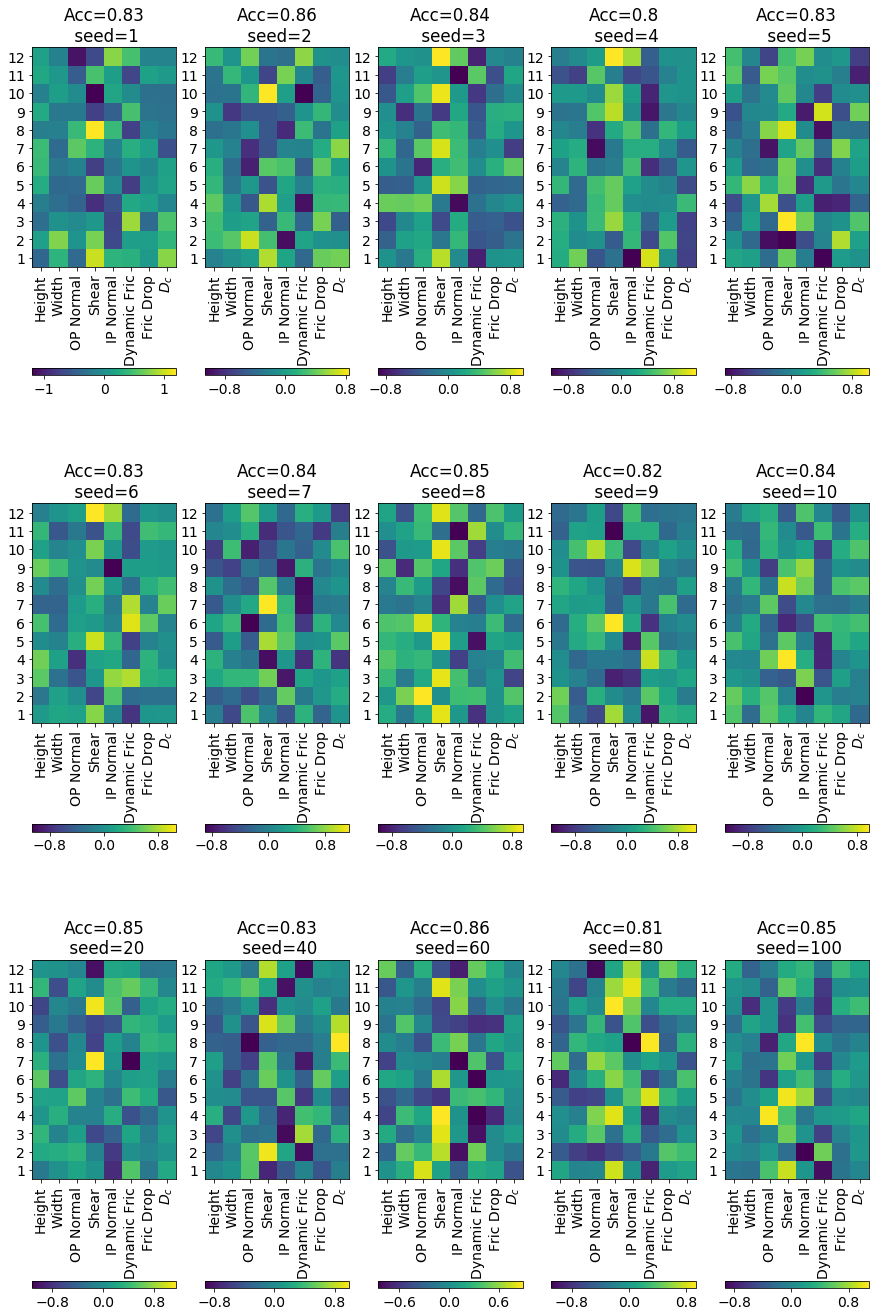

In [174]:
from matplotlib import ticker

plt.figure(figsize=(15,23))
model_weights = []
for i in range(len(random_seed)):
    filename = './logs/random_seed_'+ str(random_seed[i])+'_999.hdf5'
    loaded_model.load_weights(filename)
    weights = loaded_model.get_weights()
    layer_1_weights = weights[0]
    model_weights.append(layer_1_weights)
    plt.subplot(3,5, i+1)
    plt.pcolormesh(np.transpose(layer_1_weights))
    labels = ['Height', 'Width', 'OP Normal', 'Shear', 'IP Normal', 'Dynamic Fric', 'Fric Drop', '$D_c$']
    plt.xticks([0.5+float(x) for x in range(0,8)], labels, rotation='vertical')
    plt.yticks([0.5+float(x) for x in range(0,12)], list(range(1,13)))
#     plt.ylabel('Hidden Units')
    plt.title('Acc=%s\n seed=%s'%(round(new_scores[i], 2), random_seed[i]))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

    cb = plt.colorbar(orientation="horizontal",fraction=0.05, pad=0.3)
    tick_locator = ticker.MaxNLocator(nbins=3)
    cb.locator = tick_locator
    cb.update_ticks()

plt.savefig('weight_vs_features.eps')
plt.show()
# print(np.shape(weights[0]))

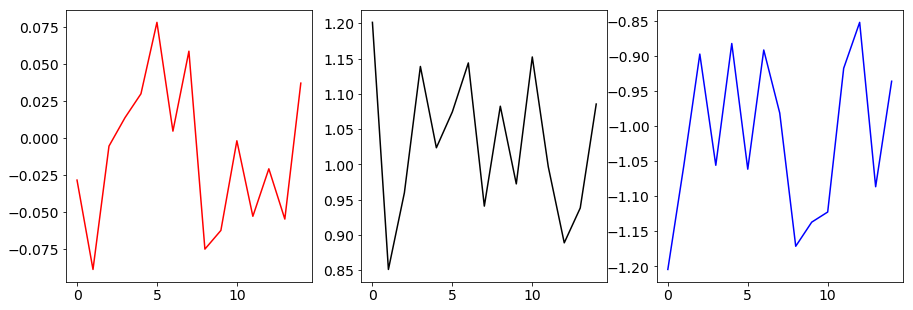

In [99]:
weight_mean =[]
weight_max =[]
weight_min =[]
for i in range(len(model_weights)):
    x = np.matrix(model_weights[i])
    weight_mean.append(x.mean())
    weight_max.append(x.max())
    weight_min.append(x.min())

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(weight_mean, '-r')

plt.subplot(1,3,2)
plt.plot(weight_max, '-k')

plt.subplot(1,3,3)
plt.plot(weight_min, '-b')
plt.show()
    

In [49]:
Y_pred = model.predict(X_test)
Y_test_class = np.argmax(Y_test, axis = 1)
Y_pred_class = np.argmax(Y_pred, axis = 1)

In [30]:
# Benchmark
pd.Series(Y_test_class).value_counts()

0    272
1    128
dtype: int64

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print(accuracy_score(Y_test_class, Y_pred_class))
print(classification_report(Y_test_class, Y_pred_class))
print('---------- Confusion matrix ----------')
confusion_matrix(Y_test_class, Y_pred_class)

0.85
             precision    recall  f1-score   support

          0       0.85      0.94      0.90       272
          1       0.85      0.65      0.73       128

avg / total       0.85      0.85      0.84       400

---------- Confusion matrix ----------


array([[257,  15],
       [ 45,  83]])

## Plot accuracy 

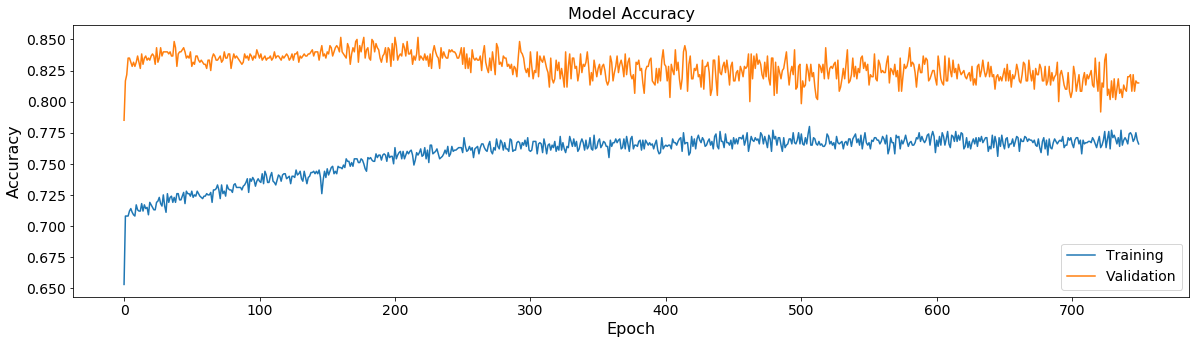

In [14]:
#print(history.history.keys())

plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(20,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy', size=16)
plt.ylabel('Accuracy', size=16)
plt.xlabel('Epoch', size=16)
plt.legend(['Training', 'Validation'], loc='lower right')


In [14]:
# model accuracy at different random seed
data = pd.DataFrame({'Random seed':[1, 5, 6, 7, 8, 9],
                     'Accuracy' : [0.8275, 0.8075, 0.845, 0.8375, 0.845, 0.8225]})
data

,Accuracy,Random seed
0,0.8275,1
1,0.8075,5
2,0.8450,6
3,0.8375,7
4,0.8450,8
5,0.8225,9
